In [30]:
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [31]:
PREFIX = "lkpp"

In [32]:
def string_replace_ruleset(ruleset: dict[str, str] = {}, default_value=None, return_unmatch=True):
    def inner_func(s: str) -> str:
        if s is None:
            return None
        
        if s is np.nan:
            return None
        
        s = s.strip()
        if s == "" or s == "-" or s == "unknown":
            return None

        for replace_with, find_what in ruleset.items():
            for substring in find_what:
                if substring.lower() in s.lower():
                    return replace_with

        if default_value is not None:
            return default_value
        
        if return_unmatch:
            return s.strip()

    return inner_func

## Data Loading

In [33]:
df_products = pd.read_json(f"../data/clean/{PREFIX}-products-filtered.jsonl", lines=True)
df_products.head(2)

,id,sku,product_name,price,stock,unit_measurement,is_inactive,expiry_date,bmp_score,tkdn_score,...,warning_wrong_category,warning_wrong_description,tag_umkk,tag_verified_vendor,tag_official_vendor,tag_produk_dalam_negeri,description,extra_description,url,category
0,83451581,4522100001-LTN-224654966,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,12500000,5.0,unit,True,1.735603e+12,NaN,99.64,...,True,True,True,True,False,True,- Processor: Intel Core™ I5- 3.70 GHz - Frekue...,LAPTOP ADMINISTRASI PERKANTORAN AXIOO\nprocess...,https://e-katalog.lkpp.go.id/katalog/produk/de...,LAPTOP
1,83451581,4522100001-LTN-224654966,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,12500000,5.0,unit,True,1.735603e+12,NaN,99.64,...,True,True,True,True,False,True,- Processor: Intel Core™ I5- 3.70 GHz - Frekue...,LAPTOP ADMINISTRASI PERKANTORAN AXIOO\nprocess...,https://e-katalog.lkpp.go.id/katalog/produk/de...,LAPTOP


In [34]:
df_specs = pd.read_json(f"../data/clean/{PREFIX}-products-specs.jsonl", lines=True)
df_specs.head(2)

,id,product_name,brand,series_model,processor,memory,storage,graphics_card
0,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8GB / 16GB DDR4 3200MHz,512GB M.2 NVMe PCIe Gen. 3 x4,Intel Iris Plus Graphic
1,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8GB / 16GB DDR4 3200MHz,512GB M.2 NVMe PCIe Gen. 3 x4,Intel Iris Plus Graphic


In [35]:
def derive_source(s: str) -> str:
    if "tokopedia.com" in s:
        return "Tokopedia"
    elif "lazada.co.id" in s:
        return "Lazada"
    
    return "LKPP"

df_products["source"] = df_products["url"].apply(derive_source)

<Axes: xlabel='source'>

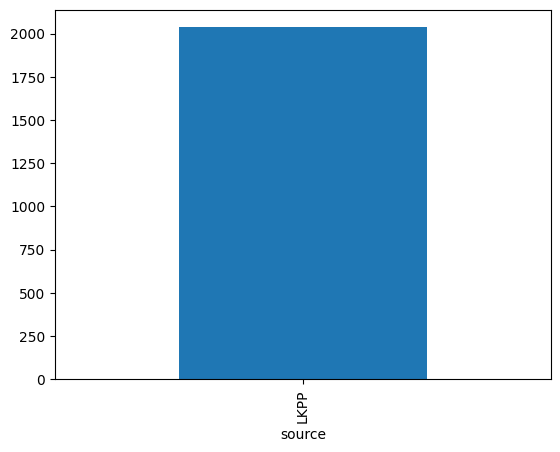

In [36]:
df_products["source"].value_counts().plot.bar()

## Feature Normalization

### Brand

In [37]:
brand_ruleset = {
    None: ["amd", "tanpa", "unknown", "intel", "itel"],
    "APPLE": ["macbook"],
    "ASUS": ["vivobook", "asus"],
    "ADVAN": ["ad van"],
    "HP": ["hewlet"],
    "LIBERA": ["merdeka", "libera"],
}

df_specs["brand_norm"] = df_specs["brand"].apply(string_replace_ruleset(brand_ruleset)).str.upper()

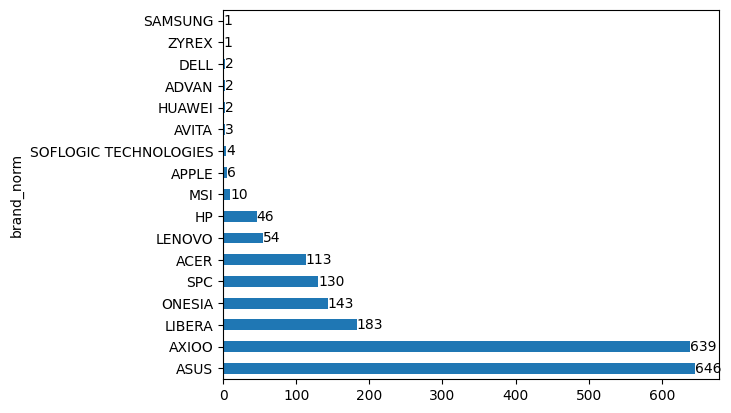

In [38]:
ax = df_specs["brand_norm"].value_counts().plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

### Processor

In [39]:
def processor_norm_intel(s: str):
    if s is None:
        return None

    s = s.lower().strip()

    # exclude non Intel CPUs
    if "snap" in s or "amd" in s or "ryzen" in s or s.startswith("r"):
        return None
    
    # edge cases: Intel Processor and Core
    if "n100" in s:
        return "Intel Processor N100"
    elif "n200" in s:
        return "Intel Processor N200"
    elif "n300" in s:
        return "Intel Core i3-N300"
    elif "100u" in s and "i3" not in s:
        return "Intel Core 3 100U"
    elif "120u" in s:
        return "Intel Core 5 120U"
    elif "150u" in s:
        return "Intel Core 7 150U"
    elif "n6000" in s:
        return "Intel Pentium Silver N6000"
    
    # Intel Ultra series
    match = re.findall(r"ultra.?(\d).+(\d{3}\w)", s, re.IGNORECASE)
    if len(match) == 1:
        return "Intel Core Ultra " + match[0][0] + " " + match[0][1].upper()
    
    # Intel Celeron
    match = re.findall(r"N(\d{4})", s, re.IGNORECASE)
    if len(match) == 1:
        return "Intel Celeron N" + match[0]
    
    # Intel Core i series
    match = re.findall(r"(i?.?\d)[- ]+(\d\w+\d?)", s, re.IGNORECASE)
    if len(match) == 1:
        return "Intel Core " + match[0][0].strip().lower() + "-" + match[0][1].upper()
    
    # edge case: Intel Core i series
    match = re.findall(r"(i\d).+(\d{4}[a-z]\d?)", s, re.IGNORECASE)
    if len(match) == 1:
        return "Intel Core " + match[0][0].strip().lower() + "-" + match[0][1].upper()
    
    # Intel Core i series without gen
    match = re.findall(r"core.?i.?(\d)", s, re.IGNORECASE)
    if len(match) == 1:
        return "Intel Core i" + match[0].strip().upper().replace("-", "")
    
    return s

In [40]:
def processor_norm_amd(s: str):
    if s is None:
        return None

    s = s.lower().strip()

    # exclude non Intel CPUs
    if "snap" in s or "amd" in s or "ryzen" in s or s.startswith("r"):
        return None

In [41]:
# passthrough
df_specs["processor_norm"] = df_specs["processor"]

In [42]:
processor_norm_amd("Intel Core i5 (in Pavilion x360 14 ek0114TU), Intel Core i7 (in Elitebook 8470p)")

In [43]:
re.findall(r"ultra.?(\d).+(\d{3}\w)", "Intel Core Ultra 7 Processor 155H 1.4 GHz (24MB Cache, up to 4.8 GHz, 16 cores, 22 Threads)", re.IGNORECASE)

[('7', '155H')]

In [44]:
df_specs["processor"].apply(processor_norm_amd).value_counts().sort_values(ascending=False).to_csv("processor_norm.txt")

In [45]:
df_specs["processor"].value_counts().sort_index().to_csv("processor.txt")

### Memory

In [46]:
def memory_norm(s):
    if s is None:
        return None
    
    s = s.lower().strip()
    
    # xx/xxx GB
    match = re.findall(r"(\d+)\/\d.+GB", s, re.IGNORECASE)
    if len(match) > 0:
        return float(match[0])
    
    # xx.0 GB
    match = re.findall(r"(\d+.0) ?GB", s, re.IGNORECASE)
    if len(match) > 0:
        return float(match[0])
    
    # xx GB
    match = re.findall(r"(\d+) ?GB", s, re.IGNORECASE)
    if len(match) > 0:
        temp = float(match[0])
        if temp > 500:
                return None

        return temp
    
    return None

df_specs["memory_norm"] = df_specs["memory"].apply(memory_norm).astype(float)

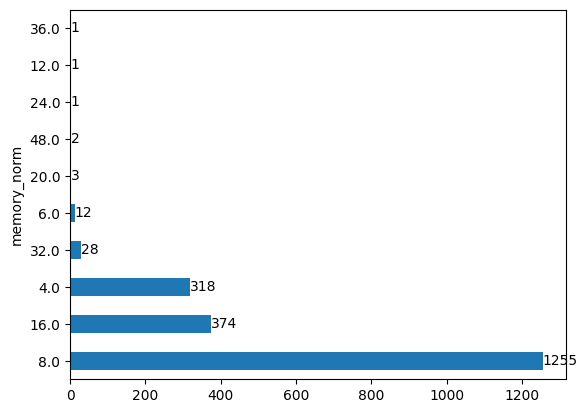

In [47]:
ax = df_specs["memory_norm"].value_counts().plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

### Storage

In [48]:
def norm_storage(s):
    if s is None:
        return None
    
    s = s.lower().strip()
    if s == "" or s == "unknown":
        return None

    # xx GB/TB
    match = re.findall(r"(\d+) ?(gb|tb|pci|ssd|m\.2|g|t)", s, re.IGNORECASE)
    if len(match) > 0:
        val = float(match[0][0])
        unit = 1024 if match[0][1].lower() == "tb" else 1
        return val * unit
    
    # xx/someting
    match = re.findall(r"(\d+)\/.+", s, re.IGNORECASE)
    if len(match) > 0:
        return float(match[0])

    return None

df_specs["storage_norm"] = df_specs["storage"].apply(memory_norm).astype(float)

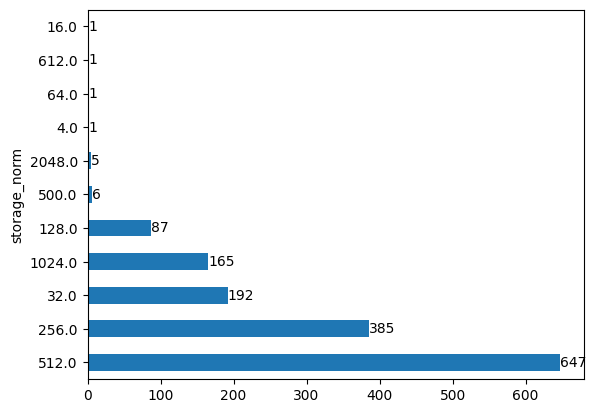

In [49]:
ax = df_specs["storage_norm"].value_counts().plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

In [50]:
storage_type_ruleset = {
    "eMMC": ["emmc", "microsd"],
    "SSD NVMe": ["nvme"],
    "SSD": ["ssd", "pcie", "pci-e", "m.2", "m. 2"],
}

df_specs["storage_type_norm"] = df_specs["storage"].apply(string_replace_ruleset(storage_type_ruleset, default_value="HDD")).str.upper()

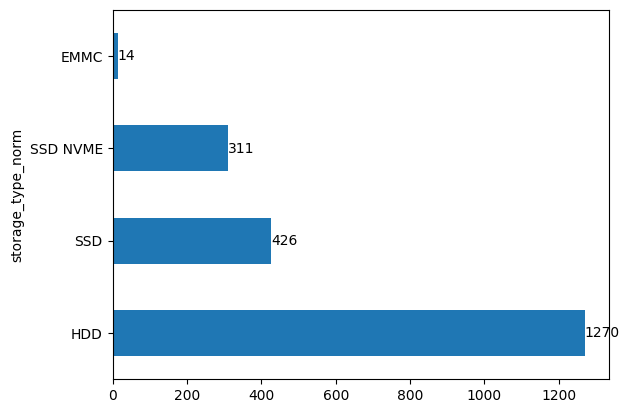

In [51]:
ax = df_specs["storage_type_norm"].value_counts().plot.barh()
ax.bar_label(ax.containers[0])
plt.show()

### Graphics Card

In [52]:
def norm_gpu(s):
    if s is None:
        return None
    
    if s is np.nan:
        return None
    
    s = s.strip()
    if s == "" or s == "-" or s == "unknown":
        return None
    
    # match NVIDIA GPUs
    match = re.findall(r"(MX|RTX|GTX) ?(\d{4}) ?(Ti|Super)?", s, re.IGNORECASE)
    if len(match) > 0:
        res = "Nvidia " + match[0][0].upper() + " " + match[0][1]
        if len(match[0]) == 3 and len(match[0][2].strip()) > 0:
            res += " " + match[0][2].strip().title()

        return res
    
    return "Integrated"

df_specs["graphics_card_norm"] = df_specs["graphics_card"].apply(norm_gpu)

<Axes: ylabel='graphics_card_norm'>

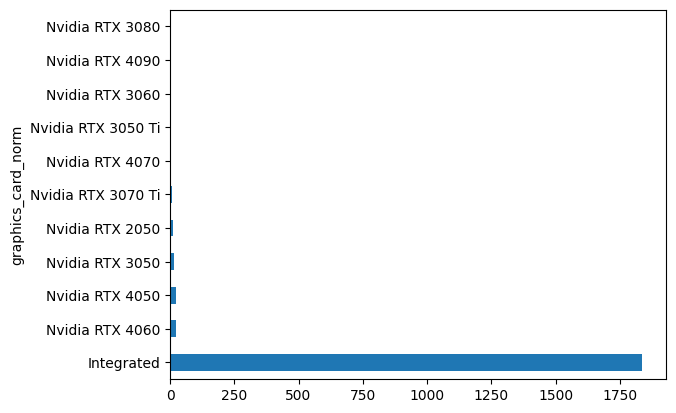

In [53]:
df_specs["graphics_card_norm"].value_counts().plot.barh()

## Merge and Save

In [54]:
df_products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 39 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          2037 non-null   int64  
 1   sku                         2037 non-null   object 
 2   product_name                2037 non-null   object 
 3   price                       2037 non-null   int64  
 4   stock                       1958 non-null   float64
 5   unit_measurement            2037 non-null   object 
 6   is_inactive                 2037 non-null   bool   
 7   expiry_date                 2036 non-null   float64
 8   bmp_score                   1802 non-null   float64
 9   tkdn_score                  1997 non-null   float64
 10  tkdn_bmp_score              1997 non-null   float64
 11  kbki_code                   2037 non-null   int64  
 12  sni_number                  0 non-null      float64
 13  brand                       1585 

In [55]:
df_specs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2037 entries, 0 to 2036
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  2037 non-null   int64  
 1   product_name        2037 non-null   object 
 2   brand               2013 non-null   object 
 3   series_model        2032 non-null   object 
 4   processor           2031 non-null   object 
 5   memory              2022 non-null   object 
 6   storage             2021 non-null   object 
 7   graphics_card       1934 non-null   object 
 8   brand_norm          1985 non-null   object 
 9   processor_norm      2031 non-null   object 
 10  memory_norm         1995 non-null   float64
 11  storage_norm        1491 non-null   float64
 12  storage_type_norm   2021 non-null   object 
 13  graphics_card_norm  1931 non-null   object 
dtypes: float64(2), int64(1), object(11)
memory usage: 222.9+ KB


In [56]:
cols_specs = ["id", "series_model", "brand_norm", "processor_norm", "memory_norm", "storage_norm", "storage_type_norm", "graphics_card_norm"]
cols_products = ["id", "product_name", "source", "final_price" if PREFIX == "ecom" else "price"]

# merge products
df_merged = df_products[cols_products].merge(df_specs[cols_specs], on="id", how="right")

In [57]:
col_rename_map = {
    "brand_norm": "brand",
    "processor_norm": "processor",
    "memory_norm": "memory_gb",
    "storage_norm": "storage_gb",
    "storage_type_norm": "storage_type",
    "graphics_card_norm": "graphics_card",
}

if PREFIX == "ecom":
    col_rename_map["final_price"] = "price"

# rename cols
df_merged = df_merged.rename(columns=col_rename_map)
df_merged.head()

,id,product_name,source,price,series_model,brand,processor,memory_gb,storage_gb,storage_type,graphics_card
0,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated
1,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated
2,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated
3,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated
4,83451581,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,LKPP,12500000,LAPTOP ADMINISTRASI PERKANTORAN AXIOO,AXIOO,Intel Core I5- 3.70 GHz - Frekuensi Turbo | Co...,8.0,NaN,SSD NVME,Integrated


In [58]:
df_merged.to_json(f"../data/clean/{PREFIX}-products-ready.jsonl", orient="records", lines=True)